# PVPS Bifacial Study: pvfactors

In [93]:
from pathlib import Path
import pandas as pd
import numpy as np
from pvlib.tools import cosd, sind
from pvlib.solarposition import get_solarposition
from pvlib.tracking import singleaxis as get_singleaxis
from pvlib.pvsystem import retrieve_sam
import datetime as dt
import matplotlib.pyplot as plt

S4_GCR = 0.35

In [69]:
%matplotlib notebook

## Pre-processing: calculate pvfactors inputs

In [30]:
def calculate_pvfactors_ft_params(clearance_height: float, mod_width: float, mod_height: float,
                                  orientation: str, tilt: float, 
                                  mod_per_row: int, mod_spacing: float):
    """Calculate pvfactors pvrow_height and module_spacing_ratio"""
    # Total spacing length
    collector_tot_spacing = (mod_per_row - 1) * mod_spacing
    # Collector width and length
    if orientation == "landscape":
        collector_width = mod_width
        collector_length = mod_per_row * mod_height + collector_tot_spacing
    else:
        collector_width = mod_height
        collector_length = mod_per_row * mod_width + collector_tot_spacing
    # Calculate pvrow_height
    pvrow_height = clearance_height + collector_width / 2. * sind(tilt)
    print("pvrow_height: {} m".format(pvrow_height))
    # Calculate spacing ratio
    spacing_ratio = collector_tot_spacing / collector_length
    print("spacing_ratio: {}".format(spacing_ratio))

In [29]:
print("S1:")
calculate_pvfactors_ft_params(0.5, 0.989, 1.991, "landscape", 20., 20, 0.01)
print("S2:")
calculate_pvfactors_ft_params(0.75, 0.989, 1.991, "landscape", 25., 20, 0.01)
print("S3:")
calculate_pvfactors_ft_params(0.3, 0.989, 1.991, "landscape", 90., 20, 0.01)
print("S4:")
calculate_pvfactors_ft_params(1.2, 0.989, 1.991, "portrait", 0., 20, 0.01)

S1:
pvrow_height: 0.6691289608745432 m
spacing_ratio: 0.0047488127968008005
S2:
pvrow_height: 0.9589847304307759 m
spacing_ratio: 0.0047488127968008005
S3:
pvrow_height: 0.7945 m
spacing_ratio: 0.0047488127968008005
S4:
pvrow_height: 1.2 m
spacing_ratio: 0.009514271407110664


## Load weather and location data

In [9]:
tmy_1 = Path('.') / 'inputs/ARE_Abu.Dhabi.412170_IWEC.epw'
tmy_2 = Path('.') / 'inputs/CHL_Antofagasta.854420_IWEC.epw'
tmy_3 = Path('.') / 'inputs/NLD_Groningen.062800_IWEC.epw'

In [92]:
def preprocess_weather(filepath: Path):
    """Preprocess weather data for pvfactors simulation:
    - import EPW irradiance data
    - calculate solar angles with the correct time offset (+30min)
    - calculate solar angle checks to make sure time offset is good
    - calculate S4 single-axis tracking angles with back-tracking (requires S4_GCR)
    """
    df, meta = pvlib.iotools.read_epw(filepath, coerce_year=2003)
    df = df[['ghi', 'dni', 'dhi']]
    # solar angles: the timestamp is the beginning of the interval, but the values are avg over interval
    solpos = get_solarposition(df.index + dt.timedelta(minutes=30), 
                               meta['latitude'], meta['longitude'], 
                               altitude=meta['altitude'])
    solpos.index = df.index
    df = df.join(solpos[['apparent_zenith', 'zenith', 'azimuth']])
    # for timestamp check of solar angles: +30 min is good
    df['ghi_calc'] = df.dhi + df.dni * cosd(df.zenith)
    df['delta'] = (df.ghi_calc - df.ghi) / df.ghi * 100.  # should be < 5%
    # sat angles
    sat_angles = get_singleaxis(df.apparent_zenith, df.azimuth, axis_azimuth=0,
                               max_angle=90, backtrack=True, gcr=S4_GCR)
    df = df.join(sat_angles.surface_tilt).rename(columns={'surface_tilt': 'S4_tilt'})
    return df

In [89]:
df = preprocess_weather(tmy_1)

<IPython.core.display.Javascript object>


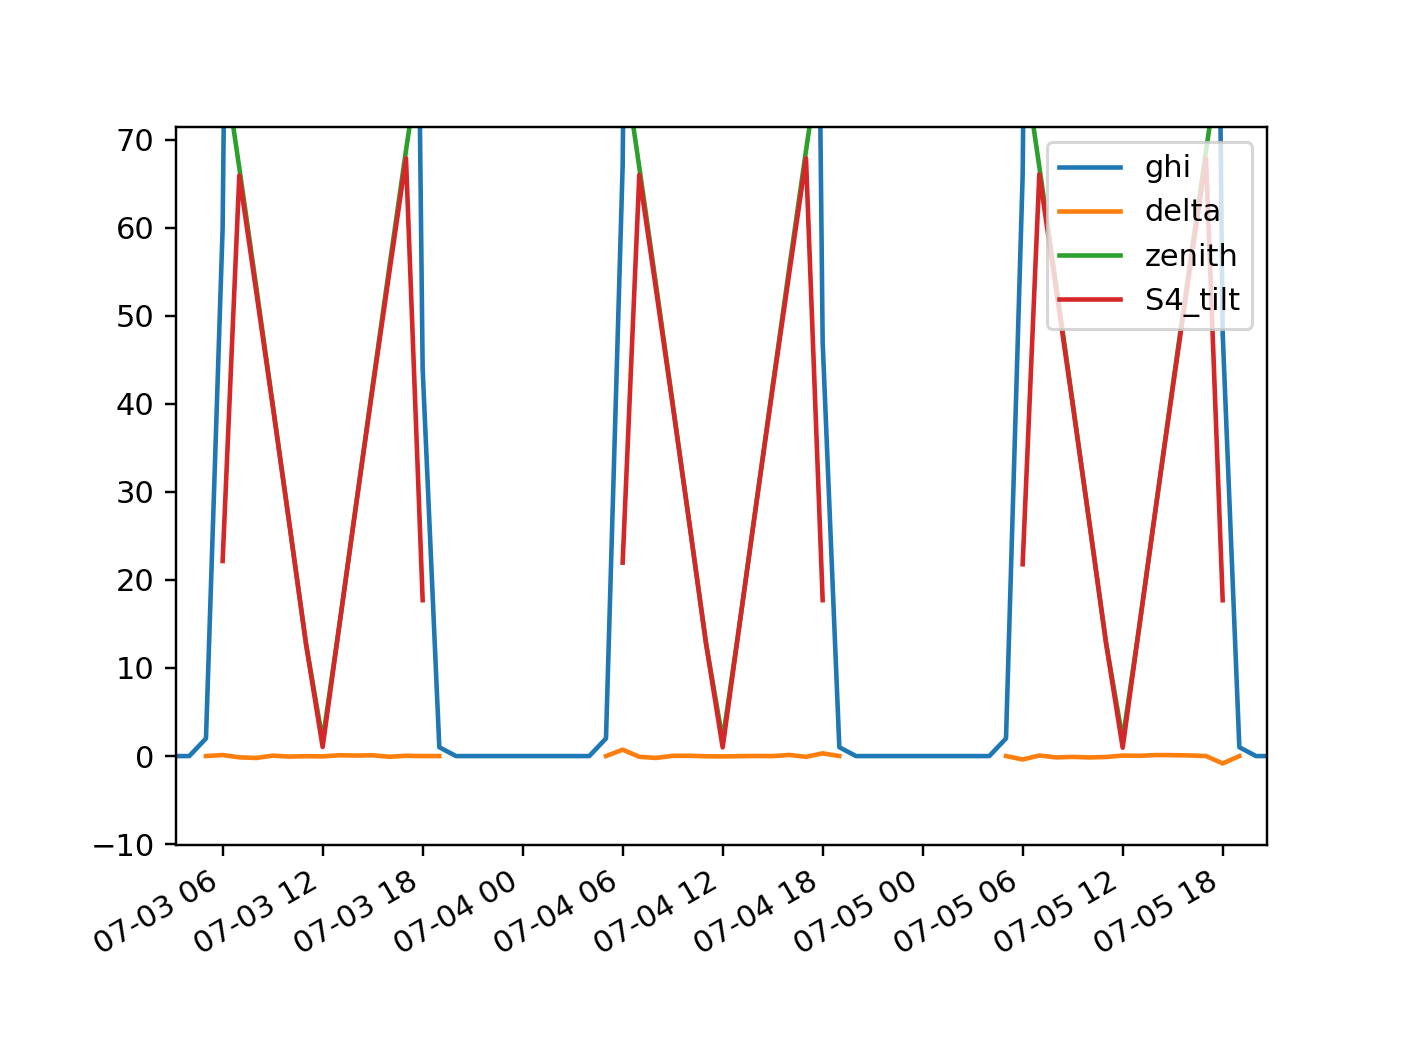

In [91]:
df[['ghi', 'delta', 'zenith', 'S4_tilt']].plot()

## Calculate the reflectivity of front and back for the PV module

Not sure what to use for the fAOI coefficients of the Prism module.
The PAN file indicates Tempered AR glass used on the front side of the module, but we don't know what's used on the back side.
So we'll randomly choose a module in the pvlib database that should probably have tempered AR glass as well: "SunPower_SPR_305_WHT___2009_"

In [94]:
sandia_modules = retrieve_sam('SandiaMod')

In [98]:
module_name = "SunPower_SPR_305_WHT___2009_"

In [99]:
from pvfactors.viewfactors.aoimethods import faoi_fn_from_pvlib_sandia

In [101]:
faoi_function = faoi_fn_from_pvlib_sandia(module_name)

In [102]:
from pvfactors.viewfactors import VFCalculator

vf_calculator = VFCalculator(faoi_fn_front=faoi_function, faoi_fn_back=faoi_function,
                             n_aoi_integral_sections=10000)

In [103]:
# For back PV row surface
is_back = True
rho_back = vf_calculator.vf_aoi_methods.rho_from_faoi_fn(is_back)
# For front PV row surface
is_back = False
rho_front = vf_calculator.vf_aoi_methods.rho_from_faoi_fn(is_back)

# Print results
print('Reflectivity values for front side: {}, and back side: {}'.format(rho_front, rho_back))

Reflectivity values for front side: 0.029355328821075943, and back side: 0.029355328821075943


/Users/marco/.virtualenvs/pvps_bifacial_study/lib/python3.6/site-packages/pvfactors/viewfactors/aoimethods.py:684: pvlibDeprecationWarning: The sapm_aoi_loss function was deprecated in pvlib 0.7 and will be removed in 0.8. Use iam.sapm instead.
  return pvlib.pvsystem.sapm_aoi_loss(angles, pvmodule, upper=1.)
